## Note
The repository that corresponds to this notebook can be found [here](https://github.com/michaeldunnpro/mddunn-thesis). Copies exported to PDF include code; this will be adapted or truncated in the final version of the thesis.

# Bethe Formalism

The Bethe stopping power formula, for nonrelativistic charged particles, is typically given by [1, p. 134]:
$$-\frac{dE}{d \ell}  = \frac{4 \pi N Z^2}{m_e v^2}\left(\frac{q_e^2}{4 \pi \epsilon_0}\right)^2 \left[ \ln \left( \frac{2 m_e v^2}{I}\right)\right],$$
where $q_e$ is the elementary charge, $Z$ is the charge of the incident particle, $m_e$ is the electron mass, $v$ is the velocity of the incident particle, $N$ is the number density of electrons in the target material, and $I$ is the mean excitation potential of the target material. We consider $\ell$ to be the path length of the incident particle through the target material, and $E$ to be the kinetic energy of the incident particle. The stopping power is defined to be precisely $- dE/d \ell$, and is a measure of the energy loss of the incident particle per unit path length through the target material. This is a statistical consequence of quantum mechanics, and is therefore an approximation of the energy loss of the incident particle; nonetheless, we can treat stopping power classically and obtain strong correspondence with actual results. Indeed, if one substitutes the classical expression for the kinetic energy of a particle, $$\frac{2 E}{m} = v^2,$$ into the Bethe formula, one obtains:
$$-\frac{dE}{d \ell}  = \frac{4\pi {q_e}^4 Z^2}{m_e v^2} N \ln\left(\frac{4 m_e E}{M I}\right)$$
which is a purely classical expression for the stopping power of a charged particle in a target material. One can further simplify this by defining a stopping power per $Z^2$ as
$$S= -\frac{1}{Z^2}\frac{dE}{d \ell}$$
and a reduced energy per ion unit mass
$$\varepsilon = \frac{E}{M},$$
which removes dependence on the incident particle's species. Doing so yields the function
$$S(\varepsilon) = \frac{2 \pi N}{\varepsilon m_e} \left(\frac{q_e^2}{4 \pi \epsilon_0}\right)^2 [\ln(4 \frac{m_e \varepsilon}{I})].$$
This will serve as a comparison point for our BCA simulation, along with experimentally measured values.

In [9]:
import numpy as np
from diamond_simulations import config as cfg
from diamond_simulations.bindings import bethe_stopping_power

## Material Parameters and References
The following are parameters used in the Bethe formula, along with their sources. I have neglected to include elementary constants, which are taken from the CODATA 2022 values [2].

The following is a table of parameters for the target material, diamond:

| Parameter | Value | Source | Description |
| --- | --- | --- | --- |
| $\rho$ | 3.51 $\text{g/cm}^3$ | [3] | Mass density |
| $I$ | 81 eV | [5] | Mean excitation potential |

Note that the atomic density of the material can be recovered as 
$$ \rho_{\alpha} = \frac{\rho}{M} $$
for an atomic mass $M$ and appropriate unit conversions. The number density of electrons can then be recovered simply as
$$ N = Z \rho_{\alpha} $$
with the atomic number $Z$ as 6 for carbon.

In [10]:
# Assume these are constants for each simulation notebook
AMU_TO_G = 1.66054e-24
CM3_TO_M3 = 0.01**3
M = 12.011*AMU_TO_G # Mass of carbon atom in g
RHO = (3.51/CM3_TO_M3)/M # Atomic density in 1/M^3
Z = 6
N = Z * RHO # Electron density
I = 81 # Ionization energy in EV
print(RHO)

# Define bethe function S for this material
def S(epsilon):
    return bethe_stopping_power(epsilon, N, I)

1.759861975960572e+29


We therefore have the following additional parameters:
| Parameter | Value | Source | Description |
| --- | --- | --- | --- |
| $M$ | 12.01 u | [4] | Atomic mass |
| $Z$ | 6 | [4] | Atomic number |
| $\rho_{\alpha}$ | 1.76 $\times 10^{23} \text{atoms/cm}^3$ | Calculated | Atomic density |
| $N$ | 1.06 $\times 10^{24} \text{electrons/cm}^3$ | Calculated | Electron density |

# Simulation

Before we begin simulating, we need to point python to the location of the RustBCA folder and a folder to output our results to. These paths are set in the cell below, and are set automatically by the makefile.

In [11]:
from IPython.display import clear_output
from diamond_simulations import config as cfg

rustbca_dir = cfg.RUSTBCA_PATH
output_dir = cfg.DEFAULT_OUTPUT_DIR

The following cells contain code for running simulations of helium, hydrogen, and lithium atoms on diamond surfaces using binary collision via RustBCA. The following collision geometry is used for all simulations:

<style>
/* Center + size */
img[alt="bca_geometry.png"],
img[alt="bcasetup.png"] {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 15%;
  max-width: 500px;
  height: auto;
}

/* Theme-adapt (dark mode) for B/W diagrams */
@media (prefers-color-scheme: dark) {
  img[alt="bca_geometry.png"],
  img[alt="bcasetup.png"] {
    filter: invert(1) brightness(1.05) contrast(1.1);
  }
}

body.jp-mod-theme-dark img[alt="bca_geometry.png"],
body.jp-mod-theme-dark img[alt="bcasetup.png"],
body[data-jp-theme-light="false"] img[alt="bca_geometry.png"],
body[data-jp-theme-light="false"] img[alt="bcasetup.png"],
.vscode-dark img[alt="bca_geometry.png"],
.vscode-dark img[alt="bcasetup.png"] {
  filter: invert(1) brightness(1.05) contrast(1.1);
}
</style>

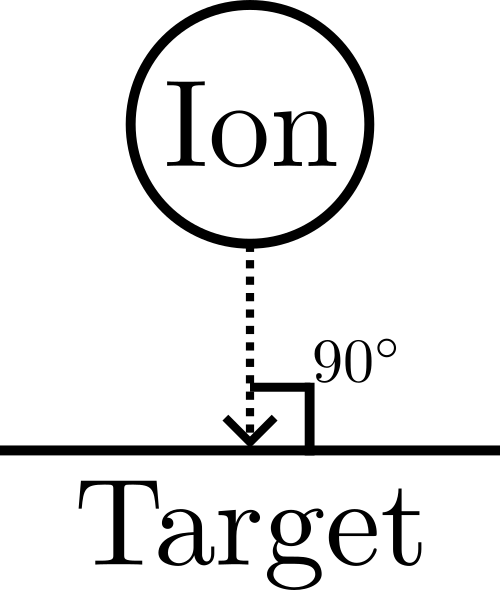

The following additional parameters are used for all simulations, and are often taken to be standard values for carbon materials in the literature:
| Parameter | Value | Source | Description |
| --- | --- | --- | --- |
| $E_s$ | 7.37 eV | [3] | Surface binding energy |
| $E_b$ | 7.42 eV | [3] | Bulk binding energy |
| $E_d$ | 52 eV | [3] | Displacement (Frankel Pair creation) energy |


In [12]:
import numpy as np
from diamond_simulations import config as cfg
from diamond_simulations.bindings import (
    build_geometry_0d,
    build_material_parameters,
    run_species_simulation,
)

diamond = cfg.diamond
hydrogen = cfg.hydrogen
helium = cfg.helium
lithium = cfg.lithium
options = cfg.options

run_sim = True
mode = "0D"
number_ions = 100
angle = 0.1
energy_read_range = np.linspace(
    0.0,
    35000,
    10001,
 )

geometry_0d = build_geometry_0d(diamond)
material_parameters = build_material_parameters(diamond)

## Hydrogen

In [13]:
hydrogen_energies = np.geomspace(1.0, 7.0, 10)  # 10 energies from 1 MeV/amu to 7 MeV/amu

run_species_simulation(
    species=hydrogen,
    energies_mev_per_amu=hydrogen_energies,
    output_filename="diamond_h_stopping_powers.csv",
    rustbca_dir=rustbca_dir,
    output_dir=output_dir,
    options=options,
    material_parameters=material_parameters,
    geometry_input=geometry_0d,
    run_sim=run_sim,
    mode=mode,
    number_ions=number_ions,
    angle_deg=angle,
    energy_read_range=energy_read_range,
    clear_output=clear_output,
 )

Hydrogen ion simulation and data processing complete.


,Incident Energy (MeV/amu),Stopping Power (KeV/um/Z^2),Percent Energy Loss (%)
0,1.000000,96.442893,33.487116
1,1.241366,78.769491,22.032601
2,1.540989,65.305966,14.715018
3,1.912931,54.540224,9.899769
4,2.374647,45.735745,6.687505
5,2.947806,38.413424,4.524719
6,3.659306,32.289999,3.063916
7,4.542537,27.140124,2.074535
8,5.638950,22.803048,1.404113
9,7.000000,19.151273,0.949964


## Helium

In [14]:
helium_energies = np.geomspace(1.25, 7.25, 10)  # Slightly offset from hydrogen energies to avoid overlap in plots

run_species_simulation(
    species=helium,
    energies_mev_per_amu=helium_energies,
    output_filename="diamond_he_stopping_powers.csv",
    rustbca_dir=rustbca_dir,
    output_dir=output_dir,
    options=options,
    material_parameters=material_parameters,
    geometry_input=geometry_0d,
    run_sim=run_sim,
    mode=mode,
    number_ions=number_ions,
    angle_deg=angle,
    energy_read_range=energy_read_range,
    clear_output=clear_output,
 )

Helium ion simulation and data processing complete.


,Incident Energy (MeV/amu),Stopping Power (KeV/um/Z^2),Percent Energy Loss (%)
0,1.250000,78.310230,21.912610
1,1.519621,66.104374,15.215298
2,1.847399,56.148953,10.630816
3,2.245877,47.859100,7.453567
4,2.730306,40.863609,5.234931
5,3.319225,34.937652,3.681651
6,4.035172,29.852271,2.587623
7,4.905546,25.513649,1.819160
8,5.963657,21.926741,1.286018
9,7.250000,18.618476,0.898239


## Lithium

In [15]:
lithium_energies = np.geomspace(1.5, 7.5, 10)  # Slightly offset from helium energies to avoid overlap in plots
run_species_simulation(
    species=lithium,
    energies_mev_per_amu=lithium_energies,
    output_filename="diamond_li_stopping_powers.csv",
    rustbca_dir=rustbca_dir,
    output_dir=output_dir,
    options=options,
    material_parameters=material_parameters,
    geometry_input=geometry_0d,
    run_sim=run_sim,
    mode=mode,
    number_ions=number_ions,
    angle_deg=angle,
    energy_read_range=energy_read_range,
    clear_output=clear_output,
 )

Lithium ion simulation and data processing complete.


,Incident Energy (MeV/amu),Stopping Power (KeV/um/Z^2),Percent Energy Loss (%)
0,1.500000,68.207914,20.636309
1,1.793720,58.354310,14.764096
2,2.144954,50.175715,10.616079
3,2.564964,43.301556,7.661446
4,3.067218,37.401271,5.533887
5,3.667819,32.350076,4.002726
6,4.386027,27.993061,2.896461
7,5.244868,24.221960,2.095864
8,6.271883,20.958589,1.516536
9,7.500000,18.132121,1.097175


# Plots

Next, we compare our obtained simulation with the Bethe stopping power formula, as well as with experimentally measured values. The following plot shows the stopping power per $Z^2$ for helium, hydrogen, and lithium atoms incident on diamond surfaces, along with the Bethe stopping power function. Experimental values are taken from [5] and [6].

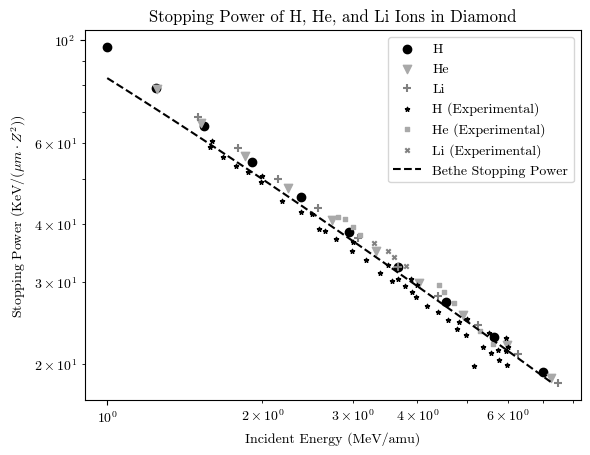

In [16]:
# Now, we have three CSV files with stopping powers for H, He, and Li ions in diamond. We can read these files and plot the stopping power as a function of incident energy for each ion species.
import pandas as pd
import matplotlib.pyplot as plt
import os
### Visual Settings ###
# Set the font family to 'serif' and the serif font to 'cmr10' (Computer Modern Roman)
plt.rcParams['font.family'], plt.rcParams['font.serif'] = 'serif', ['cmr10']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['axes.formatter.use_mathtext'] = True

# Change to data directory
os.chdir(output_dir)
# Read the CSV files
h_data = pd.read_csv('diamond_h_stopping_powers.csv')
he_data = pd.read_csv('diamond_he_stopping_powers.csv')
li_data = pd.read_csv('diamond_li_stopping_powers.csv')
# Read experimental data from literature
experimental_data = pd.read_csv('experimental_stopping_powers.csv')  # Replace with actual file path
# Separate species in experimental data
experimental_h = experimental_data[experimental_data['Species'] == 'H']
experimental_he = experimental_data[experimental_data['Species'] == 'He']
experimental_li = experimental_data[experimental_data['Species'] == 'Li']
# Plotting
plt.scatter(h_data['Incident Energy (MeV/amu)'], h_data['Stopping Power (KeV/um/Z^2)'], label='H', marker='o', color = 'black') # Change shapes for better visibility
# Imagine what it looks like in black and white
plt.scatter(he_data['Incident Energy (MeV/amu)'], he_data['Stopping Power (KeV/um/Z^2)'], label='He', marker='v', color = 'darkgray')
plt.scatter(li_data['Incident Energy (MeV/amu)'], li_data['Stopping Power (KeV/um/Z^2)'], label='Li', marker='+', color = 'gray')
plt.scatter(experimental_h['Energy (MeV/amu)'], experimental_h['Stopping Power (keV/um)'], label='H (Experimental)', marker='*', color = 'black', s=10)
plt.scatter(experimental_he['Energy (MeV/amu)'], experimental_he['Stopping Power (keV/um)'], label='He (Experimental)', marker='s', color = 'darkgray', s=10)
plt.scatter(experimental_li['Energy (MeV/amu)'], experimental_li['Stopping Power (keV/um)'], label='Li (Experimental)', marker='x', color = 'gray', s=10)
plt.xlabel('Incident Energy (MeV/amu)')
plt.ylabel('Stopping Power (KeV/$(\mu m \cdot Z^2)$)')
plt.title('Stopping Power of H, He, and Li Ions in Diamond')
# Plot the Bethe stopping power using our previously defined function S(epsilon), on the same graph for comparison
incident_energies = np.linspace(np.min(h_data['Incident Energy (MeV/amu)']), np.max(he_data['Incident Energy (MeV/amu)']), 100)
function_data = S(incident_energies)
plt.plot(incident_energies, function_data, label='Bethe Stopping Power', linestyle='--', color = 'black')
plt.legend()
plt.loglog()  # Use logarithmic scale for better visibility
plt.savefig('diamond_stopping_powers.pdf', format='pdf', bbox_inches='tight')
plt.show()

Note that the experimental data [5, 6] was obtained from diamond thin enough for the approximation
$$\frac{dE}{d \ell} \approx \frac{\Delta E}{\Delta \ell}$$
to hold, where $\Delta E$ is the energy loss of the incident particle as it passes through the diamond, and $\Delta \ell$ is the thickness of the diamond -- that's to say, deflections of incident particles are negligible. The agreement of these values indicates a three-way correspondence between our BCA simulation, the Bethe Stopping power formula, and experimental results, which strongly suggests that our BCA simulation is accurately capturing the physics of ion-solid interactions in the MeV/amu energy range.

# References

[1] Peter Sigmund, _Particle Penetration and Radiation Effects: General Aspects and Stopping of Swift Point Charges_, 1st ed. 2006. (Springer Berlin Heidelberg, Berlin, Heidelberg, 2006).

[2] P. J. Mohr, D. B. Newell, B. N. Taylor, and E. Tiesinga, “CODATA recommended values of the fundamental physical constants: 2022,” *Reviews of Modern Physics* **97**, 1 (2025).

[3] J. Gong, K. Ansari, H. Jin, and J. A. van Kan, “Cross-Sectional Investigation of Multihigh-Energy Proton-Implanted Single Crystalline Diamond,” *Physica Status Solidi (a)* **218**, 2000102 (2021).

[4] T. Prohaska *et al.*, “Standard atomic weights of the elements 2021 (IUPAC Technical Report),” **94**, 573 (2022).


[5] A. Crnjac, M. Jakšić, M. Matijević, M. Rodriguez-Ramos, M. Pomorski, and Z. Siketić, Energy loss of MeV protons in diamond: Stopping power and mean ionization energy, _Diamond and Related Materials_ **132**, 109621 (2023).


[6] R. W. Fearick and J. P. F. Sellschop, Energy loss of light ions in diamond, _Nuclear Instruments and Methods_ **168**, 51 (1980).

